In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

# Extract dataset
import os
import tarfile

import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator # Data preprocessing and augmentation

import sklearn
import numpy as np

In [0]:
print(tf.__version__)

1.15.0


In [0]:
# Make folder for chest xray data
!mkdir /content/data/

# Make directory to save weights
!mkdir /content/data/model

# Make directory to logs for Tensorboard
!mkdir /content/data/graph

# Download dataset
!wget --no-check-certificate \
    https://s3.eu-central-1.amazonaws.com/public.unit8.co/data/chest_xray.tar.gz \
    -O /content/data/chest_xray.tar.gz
  
tar = tarfile.open("data/chest_xray.tar.gz")
tar.extractall(path='./data/')
os.remove('data/chest_xray.tar.gz')

--2019-10-31 04:30:59--  https://s3.eu-central-1.amazonaws.com/public.unit8.co/data/chest_xray.tar.gz
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.151
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225393795 (1.1G) [application/x-gzip]
Saving to: ‘/content/data/chest_xray.tar.gz’

/content/data/chest 100%[===================>]   1.14G  30.0MB/s    in 40s     

2019-10-31 04:31:39 (29.2 MB/s) - ‘/content/data/chest_xray.tar.gz’ saved [1225393795/1225393795]



Change log:
> training_datagen --> ImageDataGenerator

> trainable layer --> All except base

> 20 layers VGG16 model - base, flat, dense

> **Optimizer = RMSprop(learning_rate = 0.001)**

> loss = categorical_crosscentropy

> callback = [checkpoints]

> epochs = 100

> no class weight balancing


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
[1.9448173  0.67303226]
Epoch 1/100
  1/163 [..............................] - ETA: 4:07 - loss: 0.5661 - acc: 0.7500
Epoch 00001: saving model to /content/data/model/weights.epoch_01.hdf5
163/163 [==============================] - 89s 547ms/step - loss: 0.2419 - acc: 0.8980 - val_loss: 0.5661 - val_acc: 0.7500
Epoch 2/100
  1/163 [..............................] - ETA: 56s - loss: 0.2780 - acc: 0.8125
Epoch 00002: saving model to /content/data/model/weights.epoch_02.hdf5
163/163 [==============================] - 88s 537ms/step - loss: 0.1495 - acc: 0.9419 - val_loss: 0.2780 - val_acc: 0.8125
Epoch 3/100
  1/163 [..............................] - ETA: 54s - loss: 0.8554 - acc: 0.7500
Epoch 00003: saving model to /content/data/model/weights.epoch_03.hdf5
163/163 [==============================] - 87s 537ms/step - loss: 0.1343 - acc: 0.9465 - val_loss: 0.8554 - val_

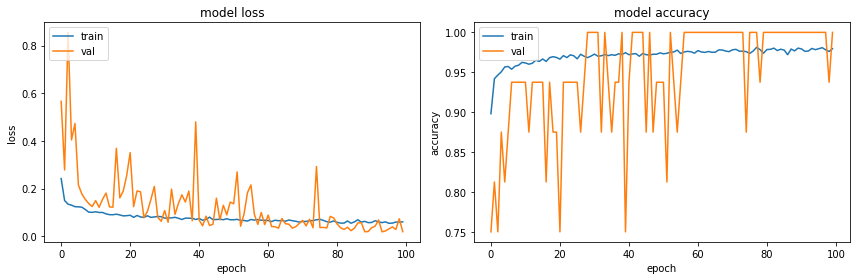

In [0]:
TRAINING_DIR = "/content/data/chest_xray/train"
VALIDATION_DIR = "/content/data/chest_xray/val"
TEST_DIR = "/content/data/chest_xray/test"

# Data preprocessing
training_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale = 1./255,
#     rotation_range=40,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    # vertical_flip=True
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Create training data batch
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(150,150),
    class_mode='categorical',
    shuffle=False
)

train_shape = train_generator.image_shape

tf.keras.backend.clear_session() # Destroys the current TF graph and creates a new one.

base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=train_shape)

# Define the machine learning model
x = base_model.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(2, 'softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x)

# for layer in model.layers[0:20]:
#     layer.trainable = False

for layer in base_model.layers:
  layer.trainable = False

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

# Callbacks stuff
# Function to save the weights of the model after each epoch
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    '/content/data/model/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_accuracy',
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# Function to stop training early if there's no improvement
early_stopping_monitor = tf.keras.callbacks.EarlyStopping(patience = 3, monitor = "val_loss", mode="auto", verbose = 1)

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='max')

classweight = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(train_generator.labels), train_generator.labels)
print(classweight)

batch_size = 32
epochs = 100

# Training process
history = model.fit_generator(
    generator=train_generator, 
    # steps_per_epoch=train_generator.samples//batch_size, 
    epochs=epochs,
    # callbacks=[early_stopping_monitor],
    callbacks=[checkpoint],
    # shuffle=True, 
    validation_data=validation_generator, 
    # validation_steps= validation_generator//batch_size, #no because it's gonna be 0... if leave alone its len(generator) which is equal to 1. 
    # class_weight=classweight,
    verbose = 1
)

## Graph loss and acc
import matplotlib.pyplot as plt
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.tight_layout()
    
plot_learning_curves(history)


## Evaualate
test_loss, test_acc = model.evaluate_generator(generator=test_generator, verbose=1)

## Load best weight
idx = np.argmin(history.history['val_loss']) 
model.load_weights("/content/data/model/weights.epoch_{:02d}.hdf5".format(idx + 1))

print("Loading the best model")
print("epoch: {}, val_loss: {}, val_acc: {}".format(idx + 1, history.history['val_loss'][idx], history.history['val_acc'][idx]))

## Evaluate the best weight
test_loss, test_acc = model.evaluate_generator(generator=test_generator, verbose=1)

## Test analytics
from sklearn.metrics import accuracy_score, confusion_matrix

test_generator.reset()
test_preds = model.predict_generator(test_generator, verbose=1)
test_preds = np.argmax(test_preds,axis=1)

acc = accuracy_score(test_generator.classes, test_preds)*100
cm = confusion_matrix(test_generator.classes, test_preds)
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)
# plot_confusion_matrix(cm, target_names=['NORMAL', 'PNEUMONIA'], normalize=False)


print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}%'.format(np.round((history.history['acc'][-1])*100, 14)))

In [0]:
## Load best weight
idx = np.argmin(history.history['acc']) 
model.load_weights("/content/data/model/weights.epoch_{:02d}.hdf5".format(idx + 1))

print("Loading the best model")
print("epoch: {}, val_loss: {}, val_acc: {}".format(idx + 1, history.history['val_loss'][idx], history.history['val_acc'][idx]))

## Evaluate the best weight
test_loss, test_acc = model.evaluate_generator(generator=test_generator, verbose=1)

## Test analytics
from sklearn.metrics import accuracy_score, confusion_matrix

test_generator.reset()
test_preds = model.predict_generator(test_generator, verbose=1)
test_preds = np.argmax(test_preds,axis=1)

acc = accuracy_score(test_generator.classes, test_preds)*100
cm = confusion_matrix(test_generator.classes, test_preds)
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)
# plot_confusion_matrix(cm, target_names=['NORMAL', 'PNEUMONIA'], normalize=False)


print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}%'.format(np.round((history.history['acc'][-1])*100, 14)))

Loading the best model
epoch: 1, val_loss: 0.5660557150840759, val_acc: 0.75
20/20 [==============================] - 7s 365ms/step
CONFUSION MATRIX ------------------
[[154  80]
 [  6 384]]

TEST METRICS ----------------------
Accuracy: 86.21794871794873%
Precision: 82.75862068965517%
Recall: 98.46153846153847%
F1-score: 89.9297423887588

TRAIN METRIC ----------------------
Train acc: 97.94861674308775%
